In [12]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [18]:
pip install yfinance --upgrade #I have had to rerun this each time to get the yahoo finance library to work

In [4]:
url = "https://raw.githubusercontent.com/Justindr1/UFO-vs-BRK-B/refs/heads/main/UFO%20Sightings.csv"
df = pd.read_csv(url)
df.head()

<ipython-input-4-a8457c07a89f>:2: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.to_period('M')

yearly_sightings = df.groupby('Year').size().reset_index(name= 'Sightings')

yearly_sightings_filtered = yearly_sightings[
    (yearly_sightings['Year'] >= 2000) & (yearly_sightings['Year'] <= 2013)]

yearly_sightings_filtered = yearly_sightings_filtered.reset_index(drop=True)
yearly_sightings_filtered

,Year,Sightings
0,2000.0,2752
1,2001.0,3109
2,2002.0,3211
3,2003.0,3935
4,2004.0,4220
5,2005.0,4039
6,2006.0,3682
7,2007.0,4243
8,2008.0,4777
9,2009.0,4508


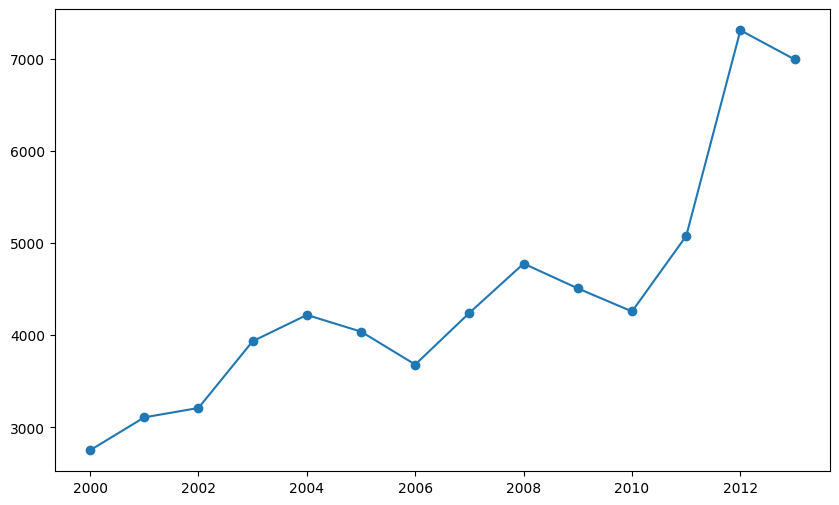

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_sightings_filtered['Year'], yearly_sightings_filtered['Sightings'], marker='o', linestyle='-')

In [7]:
# Use 'BRK-B' and specify 2000 - 2013 since the UFO data is most whole between those dates
brk = yf.download("BRK-A", start="2000-01-01", end="2013-12-31", interval="1mo")

# Keep closing prices and reset index
brk = brk[['Close']].reset_index()
brk['Year'] = brk['Date'].dt.year

# Group by year to get yearly average
brk_yearly = brk.groupby('Year')['Close'].mean().reset_index()
brk_yearly.rename(columns={'Close': 'BRK_Close'}, inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


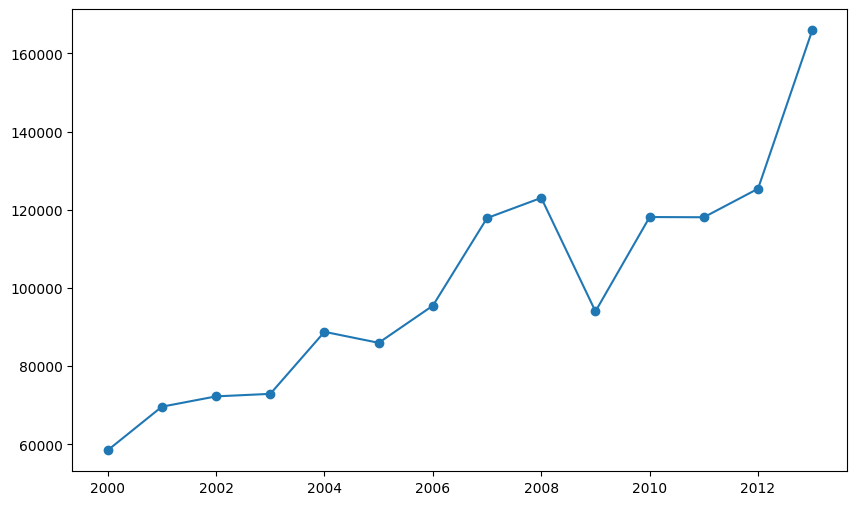

In [8]:
# Output from yahoo finance does not come in a panda dataframe
brk_yearly = pd.DataFrame(brk_yearly).reset_index(drop=True)

# Flatten column names if needed
brk_yearly.columns = [col if not isinstance(col, tuple) else col[0] for col in brk_yearly.columns]
plt.figure(figsize=(10, 6))
plt.plot(brk_yearly['Year'], brk_yearly['BRK_Close'], marker='o', linestyle='-')


In [9]:
# Join the two datasets together
merged = pd.merge(yearly_sightings_filtered, brk_yearly, on='Year')
merged

,Year,Sightings,BRK_Close
0,2000.0,2752,58491.666667
1,2001.0,3109,69637.500000
2,2002.0,3211,72274.166667
3,2003.0,3935,72917.500000
4,2004.0,4220,88781.666667
5,2005.0,4039,85967.500000
6,2006.0,3682,95470.916667
7,2007.0,4243,117874.583333
8,2008.0,4777,123032.500000
9,2009.0,4508,94004.333333


# Wow these graphs look like they follow similar trend lines! The real question is if they are actually correlated?

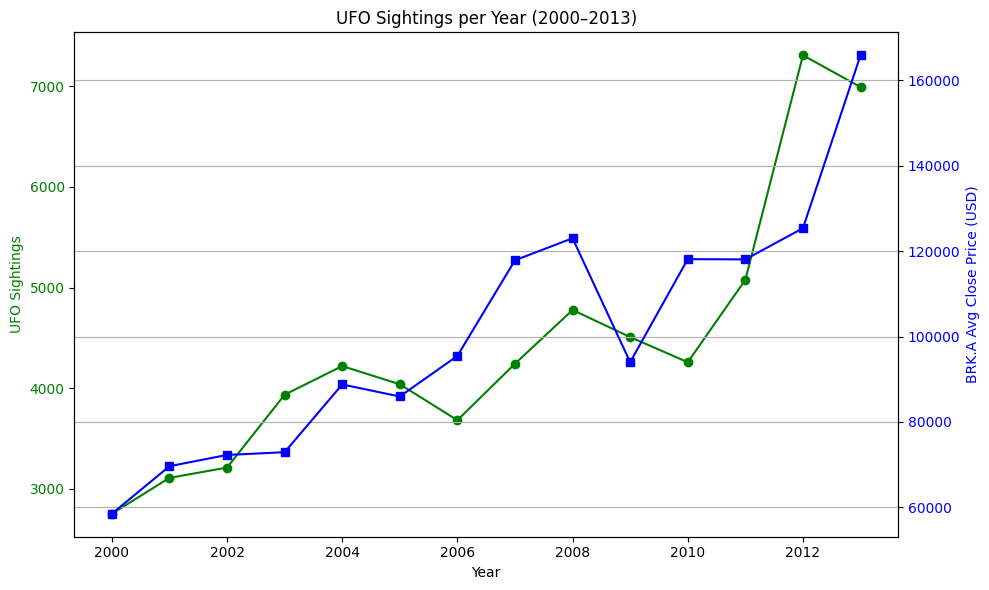

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))  # create figure and axis

# Plot UFO Sightings on ax1
ax1.plot(merged['Year'], merged['Sightings'], color='green', marker='o', label='UFO Sightings')
ax1.set_ylabel('UFO Sightings', color='green')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title('UFO Sightings per Year (2000–2013)')

# Create secondary y-axis (BRK.A stock price)
ax2 = ax1.twinx()
ax2.plot(merged['Year'], merged['BRK_Close'], color='blue', marker='s', label='BRK.A Avg Close')
ax2.set_ylabel('BRK.A Avg Close Price (USD)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.grid(True)
plt.tight_layout()
plt.show()

# Applied 0-1 Scale Noarmalization

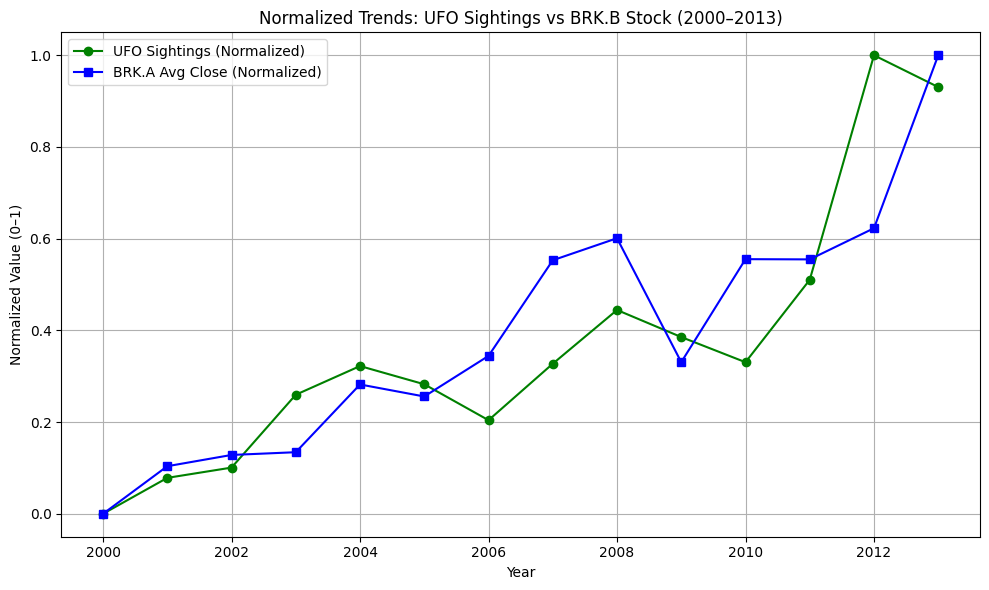

In [19]:
# Normalize both series to 0–1 scale
# Formula = (x - min(x))/max(x)-min(x)
merged['Sightings_norm'] = (merged['Sightings'] - merged['Sightings'].min()) / (merged['Sightings'].max() - merged['Sightings'].min())
merged['BRK_norm'] = (merged['BRK_Close'] - merged['BRK_Close'].min()) / (merged['BRK_Close'].max() - merged['BRK_Close'].min())

# Plot both normalized trends
plt.figure(figsize=(10, 6)) #Set size of plot to be 10in wide and 6in tall
plt.plot(merged['Year'], merged['Sightings_norm'], label='UFO Sightings (Normalized)', color='green', marker='o')
plt.plot(merged['Year'], merged['BRK_norm'], label='BRK.A Avg Close (Normalized)', color='blue', marker='s')

plt.title('Normalized Trends: UFO Sightings vs BRK.B Stock (2000–2013)')
plt.xlabel('Year')
plt.ylabel('Normalized Value (0–1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Set up regression

In [14]:
# X = UFO sightings
X = merged[['Sightings']]

# y = BRK.B average closing price
y = merged['BRK_Close']

In [15]:
model = LinearRegression()
model.fit(X,y)

slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X,y)

print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_squared:.2f}")

Slope: 18.79
Intercept: 17079.28
R-squared: 0.72


## **Despite the visual alignment, my regression shows that this relationship is as imaginary as flying saucers over Wall Street!**

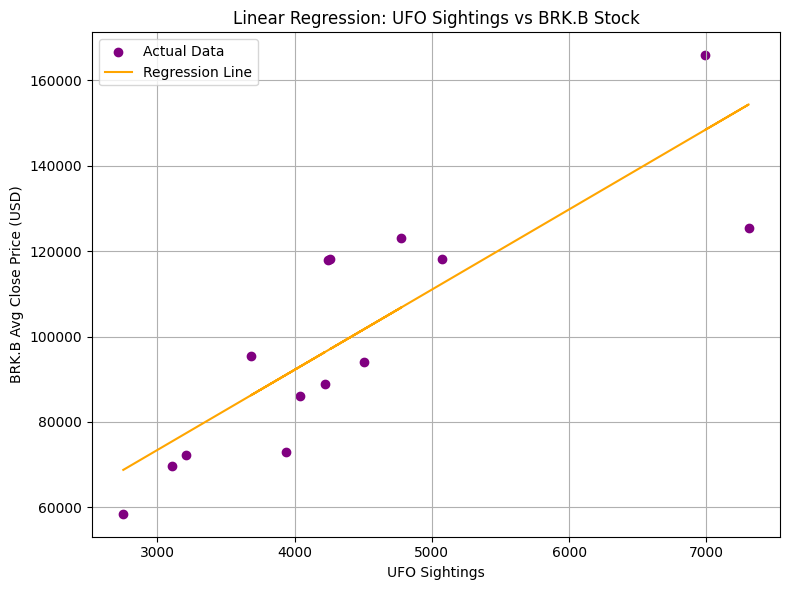

Slope: 18.79
Intercept: 17079.28
R-squared: 0.72


In [17]:
#predict y values using the model
y_pred = model.predict(X)

#Plot
plt.figure(figsize=(8,6))
plt.scatter(X, y, color='purple', label='Actual Data')
plt.plot(X, y_pred, color='orange', label= 'Regression Line')

plt.title('Linear Regression: UFO Sightings vs BRK.B Stock')
plt.xlabel('UFO Sightings')
plt.ylabel('BRK.B Avg Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_squared:.2f}")

**Note**: The scale does not start at zero as the Avg Closing price and UFO sightings for the overlapping years does not start at zero.